<a href="https://colab.research.google.com/github/astutikumari/ML-bootcamp/blob/main/Movie_Rating_Prediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Movie Rating Prediction Model

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import shap
import warnings
warnings.filterwarnings('ignore')

Load the dataset with proper encoding

In [18]:
df = pd.read_csv("IMDb Movies India.csv", encoding='ISO-8859-1')


Preprocessing: Handle missing values, convert types

Drop rows with missing target (Rating)

In [19]:
df = df[df['Rating'].notnull()]


 Clean and convert columns

In [20]:
df['Year'] = df['Year'].str.extract(r'(\d{4})').astype(float)
df['Duration'] = df['Duration'].str.extract(r'(\d+)').astype(float)
df['Votes'] = df['Votes'].str.replace(',', '').astype(float)


Fill missing values with mode or median

In [26]:
df['Year'].fillna(df['Year'].median(), inplace=True)
df['Duration'].fillna(df['Duration'].median(), inplace=True)
df['Votes'].fillna(0, inplace=True)
df['Genre'].fillna('Unknown', inplace=True)
df['Director'].fillna('Unknown', inplace=True)
df['Actor 1'].fillna('Unknown', inplace=True)



Encode categorical columns

In [28]:
label_encoders = {}
for col in ['Genre', 'Director', 'Actor 1']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

Feature Engineering: Director Success Rate

In [29]:
df['Director_Success_Rate'] = df['Director'].map(df.groupby('Director')['Rating'].mean())
df['Genre_Average_Rating'] = df['Genre'].map(df.groupby('Genre')['Rating'].mean())

Define features and target

In [30]:
features = ['Year', 'Duration', 'Votes', 'Genre', 'Director'
            , 'Actor 1','Director_Success_Rate', 'Genre_Average_Rating']
target = 'Rating'

X = df[features]
y = df[target]

Train/test split

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

 Model Training: Use XGBoost

In [32]:
model = XGBRegressor(n_estimators=100, random_state=42, learning_rate=0.1)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

Predict and evaluate

In [33]:
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.2f}")


Root Mean Squared Error (RMSE): 0.78
R-squared (R²): 0.68


Pipelines for Random Forest and XGBoost

In [34]:
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=42))
])

xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBRegressor(random_state=42))
])

 Model Comparison via Cross-validation

In [35]:
rf_scores = cross_val_score(rf_pipeline, X, y, cv=5, scoring='r2')
xgb_scores = cross_val_score(xgb_pipeline, X, y, cv=5, scoring='r2')

print("Random Forest CV R² scores:", rf_scores)
print("Random Forest CV Mean R²:", np.mean(rf_scores))
print("XGBoost CV R² scores:", xgb_scores)
print("XGBoost CV Mean R²:", np.mean(xgb_scores))


Random Forest CV R² scores: [0.65603552 0.6766381  0.67839673 0.67358225 0.67471441]
Random Forest CV Mean R²: 0.6718734024052407
XGBoost CV R² scores: [0.63621832 0.65974704 0.67448146 0.65796202 0.67054544]
XGBoost CV Mean R²: 0.659790856221449


Hyperparameter Tuning (XGBoost)

In [36]:
xgb_params = {
    'xgb__n_estimators': [50, 100],
    'xgb__max_depth': [3, 5],
    'xgb__learning_rate': [0.05, 0.1]
}
grid = GridSearchCV(xgb_pipeline, param_grid=xgb_params, cv=3, scoring='r2')
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Best XGBoost RMSE: {rmse:.2f}")
print(f"Best XGBoost R²: {r2:.2f}")


Best XGBoost RMSE: 0.77
Best XGBoost R²: 0.68


Visualization: Actual vs Predicted

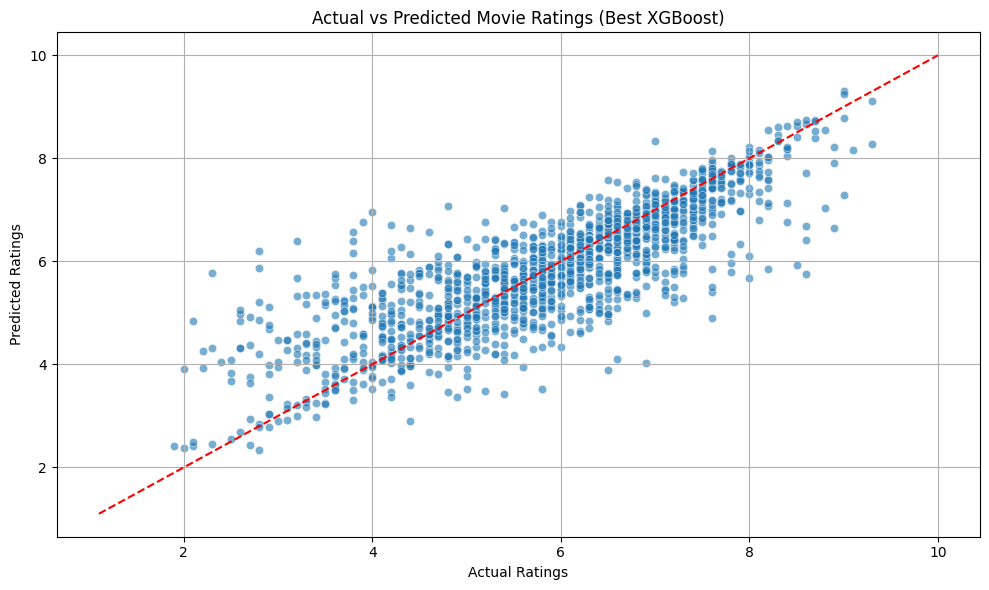

In [38]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r')
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Actual vs Predicted Movie Ratings (Best XGBoost)")
plt.grid(True)
plt.tight_layout()
plt.show()

Explainability with SHAP

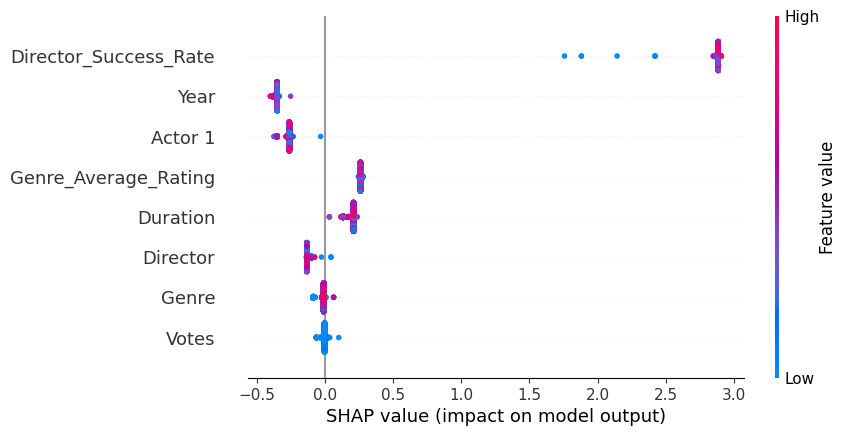

In [39]:
explainer = shap.Explainer(best_model.named_steps['xgb'])
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values)